In [1]:
from utils import FishEyeImage, rot
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from scipy.optimize import minimize, curve_fit
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, angular_separation, position_angle, offset_by, ICRS
from PIL import Image
from photutils.aperture import CircularAperture
from scipy.optimize import minimize, curve_fit, differential_evolution



In [2]:
file = 'img-e'

zhangbei = EarthLocation(lon=115*u.deg+14*u.arcsec,lat=41*u.deg+13*u.arcmin+53*u.arcsec,height = 1466)
dunhuang  = EarthLocation(lon=94.322799*u.deg,lat=40.359581*u.deg,height = 1100)
lenghu = EarthLocation(lon=93.9018774741078*u.deg,lat=38.59868881470391*u.deg,height = 3500)
pic = FishEyeImage(file+'.CR3',loc = zhangbei,mag_limit=6.5)

solution = pic.solve(solve_size=800)

{'ra': 3.9181618862146412, 'dec': 0.5182129503054203, 'eq_roll': 0.9821552964640241}


Using existing star detection data


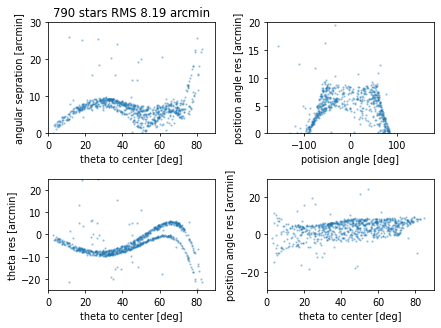

c:\Users\mlang\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mlang\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\mlang\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\mlang\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\mlang\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [3]:
rms = pic.initial_xmatch()
pic.draw_residual(alpha=0.3,dpi=70,s=2)
pic.outlier_cliping(clip_data='a_sep', theta_range=(0,85), bin_n=7, sigma=1.5)
pic.outlier_cliping(clip_data='a_sep', theta_range=(0,90), bin_n=15, sigma=1.5)


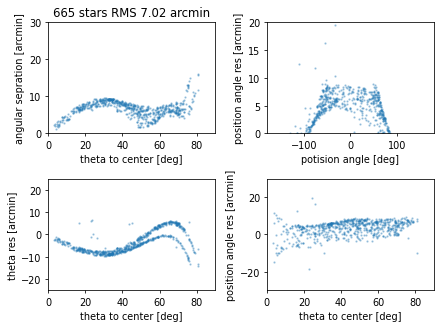

In [4]:
pic.draw_residual(alpha=0.3,dpi=70,s=2)

In [5]:
print(pic.plat_para)

{'lon': 1.2308541952750272, 'lat': 0.4127183958447982, 'roll': 6.3138495719047665, 'cu': 3000.0, 'cv': 2000.0}


{'lon': 1.223457606628973, 'lat': 0.41312038284687214, 'roll': 6.310748582744122, 'cu': 2982.101353406188, 'cv': 1999.6530050250383}
{'f': 14.557632400106677, 'k': -0.16850892571847254, 'ks': array([0., 0., 0., 0.])}


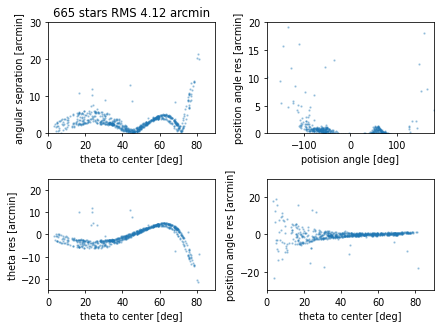

In [6]:
result  = pic.optimize(minmize_func=differential_evolution)
print(pic.plat_para)
print(pic.lens_para)
pic.draw_residual(alpha=0.3,dpi=70,s=2)

In [7]:
# im_u = pic.stars_uv[0]
# im_v = pic.stars_uv[1]
# img =  Image.open(file+'.jpg')

# cata_x,cata_y,_,_ = pic.wcs2xy(pic.catalog_lon,pic.catalog_lat)
# cata_u, cata_v = pic.xy2uv(cata_x,cata_y)
# %matplotlib qt
# plt.imshow(img)

# star = CircularAperture(np.transpose([im_u,im_v]), r=5)
# _ = star.plot(color='red', lw=1.5)

# cata = CircularAperture(np.transpose([cata_u, cata_v]), r=5)
# _ = cata.plot(color='blue', lw=1.5)
# plt.show()

(-0.00863953151504992, 0.02095665717965739, -0.012888639075910492, 0.0018715095595592973)


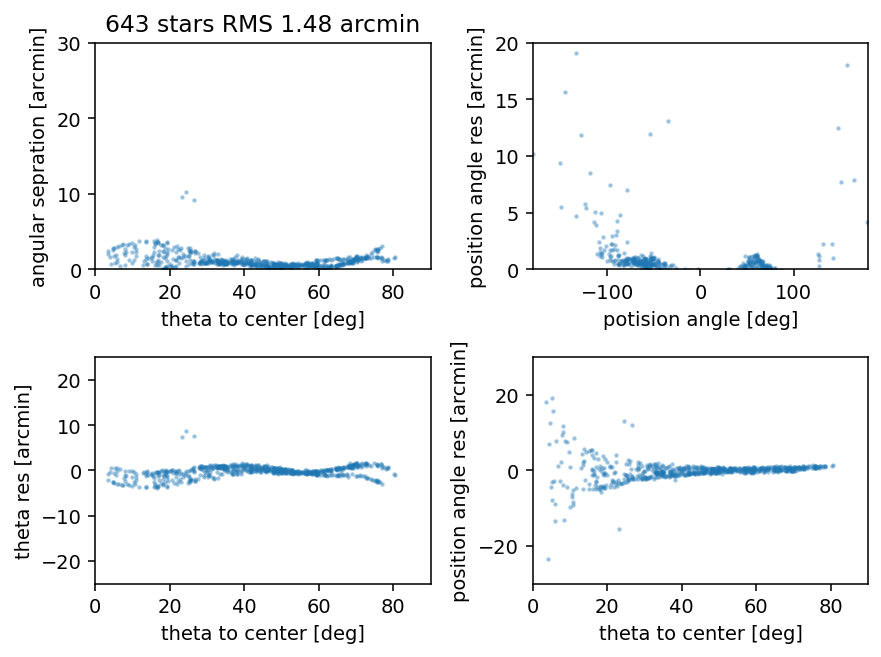

In [8]:
pic.outlier_cliping(clip_data='a_sep', theta_range=(0,70), bin_n=10, sigma=2)
pic.outlier_cliping(clip_data='pa', theta_range=(40,90), bin_n=6, sigma=2)
result  = pic.distort_optimize()
print(result)
pic.draw_residual(alpha=0.3,dpi=140,s=2)

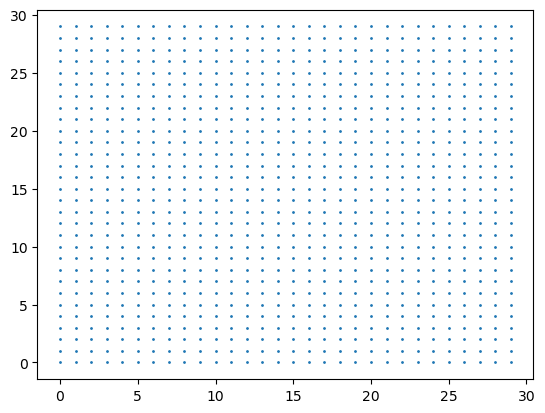

In [9]:
g = np.mgrid[0:30, 0:30]
import matplotlib.pyplot as plt
plt.scatter(g[0].flatten(),g[1].flatten(), s=1)

In [10]:
resolution=20
[sample_y,sample_x]=np.mgrid[0:4000//resolution,0:6000//resolution]*resolution+(resolution/2-0.5)
pic.uv2xy(sample_x.flatten(),sample_y.flatten())

(array([ 2071.32131516,  2070.77011945,  2070.21892374, ...,
        -2070.87203586, -2071.42323157, -2071.97442729]),
 array([ 2916.62404143,  2896.63163829,  2876.63923515, ...,
        -2911.4317444 , -2931.42414754, -2951.41655068]))

In [11]:
# im_u = pic.stars_uv[0]
# im_v = pic.stars_uv[1]
# img =  Image.open(file+'.jpg')
# plt.imshow(img)

# star = CircularAperture(np.transpose([im_u,im_v]), r=5)
# _ = star.plot(color='red', lw=1.5)